In [34]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from scipy import ndimage
import pandas as pd
import itertools as it
import networkx as nx
import os
import glob
import sys
from pathlib import Path
from scipy.optimize import minimize, Bounds

In [35]:
# allow for import of my python modules
module_path = str(Path.cwd().parents[0] / "python")

if module_path not in sys.path:
    sys.path.append(module_path)

from modules import datahandling, spatial

In [94]:
years = ['2015', '2016', '2017']
begin = '08-15 18:00:00'
end = '11-15 10:00:00'
vid_data = {}
radars = {}
t_range = {}

for y in years:
    path = f'/home/fiona/radar_data/vpi/night_only/{y}0801T0000_to_{y}1130T2359'
    vid_data[y], radars[y], t_range[y] = datahandling.load_data(path, 'vid', f'{y}-{begin}', f'{y}-{end}', '1H', mask_days=True)

In [138]:
y = '2016'
names = radars[y]
names_r = {v : k for k,v in names.items()}
time = t_range[y]
space = spatial.Spatial(names)
adj, voronoi, G = space.voronoi(plot=False)

# graph without sink nodes
G = space.subgraph('type', 'measured')
adj = nx.to_numpy_matrix(G)

#G_sink = space.subgraph('type', 'sink')

#data = np.zeros((len(G), len(time)))

data = np.stack([v.data.flatten() for k, v in vid_data[y].items()])
N, T = data.shape
vid_max = np.nanmax(data)
#data = np.concatenate([data, vid_max*np.ones((len(G_sink), T))])

In [150]:
def wrap(w, shape, adj):
    count = 0
    W = []
    for i in range(shape[0]):
        w_i = []
        for j in range(shape[1]):
            if adj[i,j] >= 1:
                w_i.append(w[count])
                count += 1
            else:
                w_i.append(0)
        W.append(w_i)
    return np.vstack(W)

def wrap2(w, shape, adj):
    W = np.zeros(shape)
    idx = np.where(adj>0)
    W[idx] = w
    return W

w = np.random.rand(np.where(adj>0)[0].size)
print(w.size)
W = wrap(w, adj.shape, adj)
W[np.where(adj>=1)] == w

A = np.ones((4,4))
A[0,1] = 2
print(A)
print(np.sum(A, axis=0))

122
[[1. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[4. 5. 4. 4.]


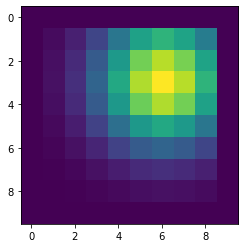

In [78]:
L = 10
boundary = [0, L-1]
S = np.zeros((L, L))
S[int(L/3), int(2*L/3)] = 1
S = ndimage.gaussian_filter(S, [2, 2])
S[boundary, :] = 0
S[:, boundary] = 0
S_new = S.copy()
w = np.array([0.4, 0.4, 0, 0, 0.2])

#G = nx.Graph()
G = nx.grid_2d_graph(L,L)
labels = {(i,j) : n for n, (i,j) in enumerate(it.product(range(L), repeat=2))}
labels_r = {v : k for k,v in labels.items()}
G = nx.relabel_nodes(G, labels)
nodes = {n : (True if (i in boundary or j in boundary) else False) for n, (i,j) in enumerate(it.product(range(L), repeat=2))}
#G.add_nodes_from(list(nodes.keys()))
nx.set_node_attributes(G, nodes, 'boundary')
G.add_edges_from([(n, n) for n in G.nodes])

#G = nx.grid_2d_graph(L,L)
#M = nx.adjacency_matrix(G)
plt.imshow(S)

In [79]:
def simulate(L, T, G):
    S = np.zeros((L, L))
    x = np.random.randint(0,L)
    y = np.random.randint(0,L)
    w = np.array([0.4, 0.4, 0, 0, 0.2])
    S[x, y] = 100
    S = ndimage.gaussian_filter(S, [2, 2])
    S[boundary, :] = 0
    S[:, boundary] = 0
    S_new = S.copy()
    dummy_data = np.zeros((L*L, T))
    for t in range(T):
        for (i,j) in it.product(range(L), repeat=2):
            if i in boundary or j in boundary:
                S_new[i,j] = S[i,j]
            else:
                nn = np.array([S[i,j], S[i-1,j], S[i,j-1], S[i+1,j], S[i,j+1]])
                S_new[i,j] = w.dot(nn)
            dummy_data[labels[(i,j)],t] = S_new[i,j]
        S = S_new.copy()
    return dummy_data

In [83]:
dummy_data = np.concatenate([simulate(L, 10, G) for r in range(5)], axis=1)
print(dummy_data.shape)
dummy_data /= dummy_data.max() * 0.2
res, targets, sources = run_optimization(dummy_data[:,:-1].T, dummy_data[:,1:], G, constraints=True)
for i, node in enumerate(targets):
    out_flux = res.x[np.where(sources==node)].sum()
    print(f'{i}: total flux = {out_flux}, \n weights = {res.x[np.where(sources==node)]}')

(100, 50)
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 411.07230999025285
            Iterations: 105
            Function evaluations: 276
            Gradient evaluations: 105
0: total flux = 1.0000000000008387, 
 weights = [0.14802774 0.12526223 0.72671003]
1: total flux = 1.0000000000025202, 
 weights = [0.18800529 0.02141126 0.20837151 0.58221194]
2: total flux = 1.0000000000023523, 
 weights = [2.32546033e-01 2.41755731e-04 2.35969344e-01 5.31242867e-01]
3: total flux = 1.0000000000022093, 
 weights = [2.81477655e-01 2.20921159e-04 1.28732740e-01 5.89568684e-01]
4: total flux = 1.0000000000005447, 
 weights = [2.98961506e-01 4.19314223e-04 7.29138603e-02 6.27705320e-01]
5: total flux = 1.0000000000015477, 
 weights = [0.35691706 0.00131411 0.04358288 0.59818595]
6: total flux = 1.0000000000002751, 
 weights = [4.07273878e-01 4.05595537e-02 2.95168945e-04 5.51871399e-01]
7: total flux = 1.0000000000000355, 
 weights = [4.10346525e-01 3

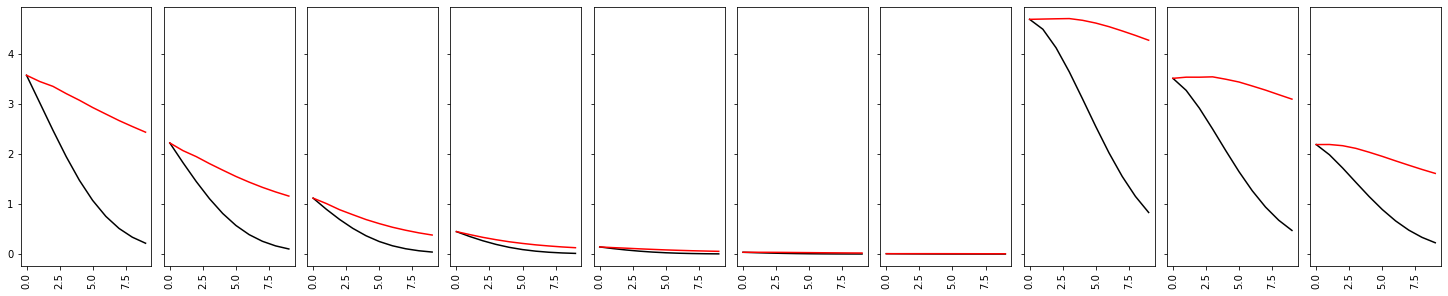

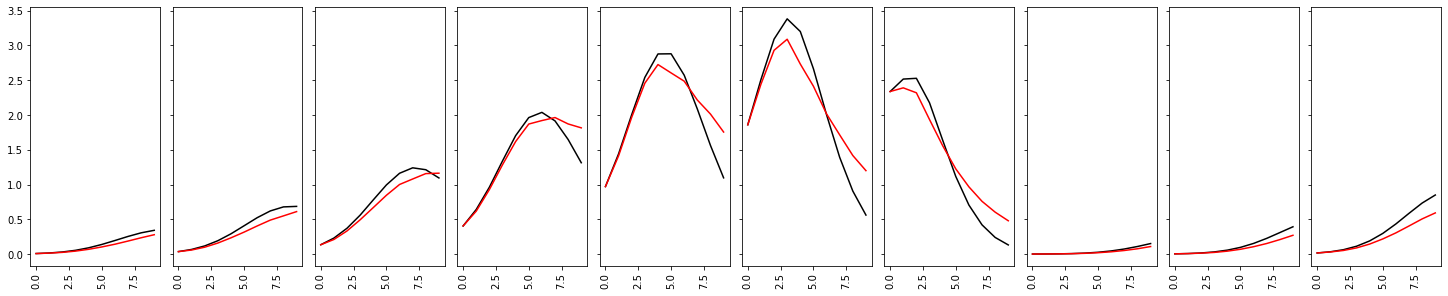

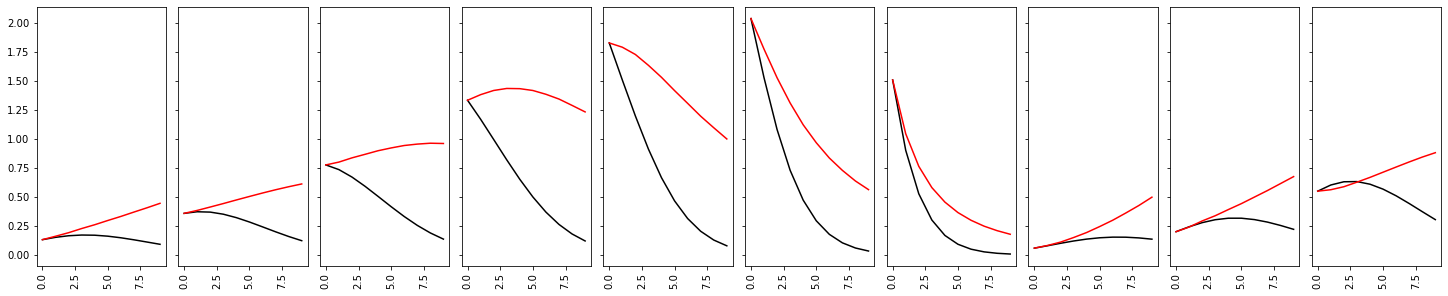

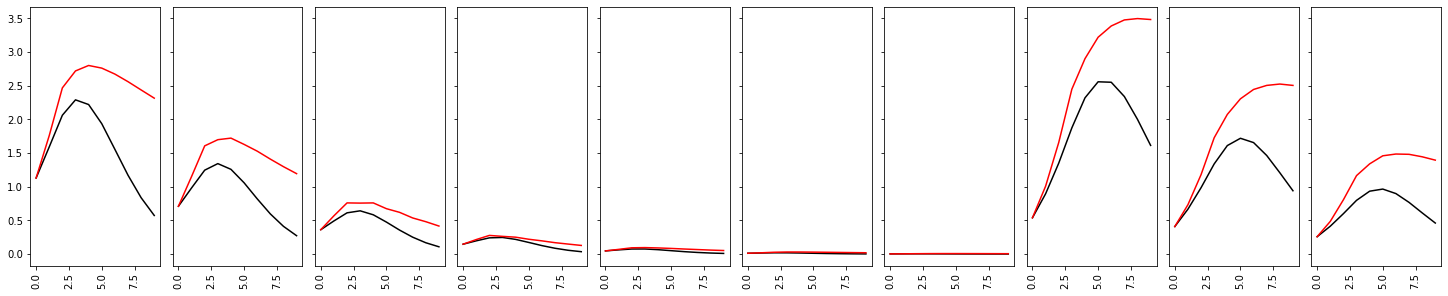

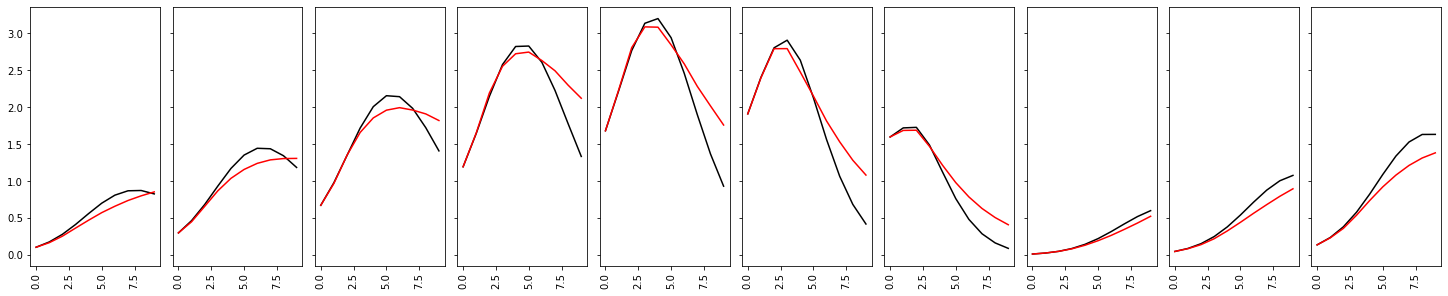

In [88]:
W = weights_to_matrix(res.x, G, targets)
T = 10
scale = dummy_data.max() * 0.2
for test in range(5):
    gt = simulate(L, T, G) / scale
    #pred = W.dot(gt[:,:-1])
    pred = gt.copy()
    for t in range(T-1):
        pred[targets, t+1] = W.dot(pred[:,t])
    #pred = np.concatenate([gt[targets,0].reshape((len(targets), 1)), pred], axis=1)
        
    fig, ax = plt.subplots(1, len(targets[25:35]), figsize=(20, 4), constrained_layout=True, sharey=True)
    for idx, node in enumerate(targets[25:35]):
        ax[idx].plot(gt[node, :]*scale, color='black')
        ax[idx].plot(pred[node, :]*scale, color='red')
        ax[idx].tick_params(axis='x', rotation=90)

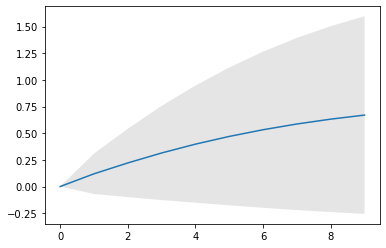

In [89]:
W = weights_to_matrix(res.x, G, targets)

errors = []
T = 10
for test in range(5):
    gt = simulate(L, T, G) /scale
    #pred = W.dot(gt[:,:-1])
    pred = gt.copy()
    for t in range(T-1):
        pred[targets, t+1] = W.dot(pred[:,t])
    errors.append((gt[targets]-pred[targets])*scale)
errors = np.abs(np.concatenate(errors))

fig, ax = plt.subplots()
mu = np.mean(errors, axis=0)
std = np.std(errors, axis=0)
ax.plot(mu)
ax.fill_between(range(10), mu+std, mu-std, facecolor='gray', alpha=0.2);

In [110]:
# create night index
check = np.isfinite(data).all(axis=0) # use if mask_days=True
check = (np.nan_to_num(data)>0).all(axis=0)
dft = pd.DataFrame({'check' : np.append(np.logical_and(check[:-1], check[1:]), False), 
                    'tidx' : range(T)},
                   index=t_range[y])

groups = [list(g) for k, g in it.groupby(enumerate(dft.check), key=lambda x: x[-1])]
nights = [[item[0] for item in g] for g in groups if g[0][1] and len(g)>6]

# train-test split based on nights
test_size = int(0.2 * len(nights))
idx = np.random.permutation(len(nights))
test_idx, train_idx = idx[:test_size], idx[test_size:]

X_seq = data / (vid_max * 0.2)




# train-test split based on date
split = '08-20'
test_tidx = dft[:f'{y}-{split}'].check
train_tidx = dft[f'{y}-{split}':].check
test_size = test_tidx.sum()

X = data[:,dft.check]
Y = np.roll(data, -1, axis=1)[:,dft.check]

scale = X.max() * 0.2
X /= scale
Y /= scale

test_size = 100

X_train = X[:, test_size:].T
Y_train = Y[:, test_size:]
X_test  = X[:, :test_size].T
Y_test  = Y[:, :test_size]

In [118]:
D = np.stack([data[:,tidx[:6]] for tidx in nights], axis=1)
D.shape

(22, 14, 6)

In [108]:
res, targets, sources = run_optimization_seq(X_seq.T, np.array(nights)[train_idx], G, constraints=True)
for i, node in enumerate(targets):
    out_flux = res.x[np.where(sources==node)].sum()
    print(f'{i}: total flux = {out_flux}, \n weights = {res.x[np.where(sources==node)]}')

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3080917697467.75
            Iterations: 3
            Function evaluations: 392
            Gradient evaluations: 3
0: total flux = 1.8464315281610961, 
 weights = [0.18096567 0.95212936 0.00644321 0.70689328]
1: total flux = 2.3262229244042665, 
 weights = [0.7391526  0.41783819 0.99908112 0.17015102]
2: total flux = 4.5741753794117965, 
 weights = [0.89676517 0.80260336 0.85009321 0.45768917 0.01974386 0.58498263
 0.04644705 0.91585092]
3: total flux = 2.3714177009652517, 
 weights = [0.76131833 0.8442868  0.47145158 0.29436099]
4: total flux = 4.586167928472508, 
 weights = [0.28186496 0.81991424 0.97812408 0.94553244 0.70892735 0.8232333
 0.02857156]
5: total flux = 3.4067574652895596, 
 weights = [0.83782656 0.07239082 0.97861475 0.56930184 0.48428993 0.20100068
 0.26333288]
6: total flux = 3.038248209053905, 
 weights = [0.60570239 0.329882   0.36359996 0.37770822 0.53390839 0.46596584
 0.03

In [97]:
res, targets, sources = run_optimization(X_train, Y_train, G, constraints=True)
for i, node in enumerate(targets):
    out_flux = res.x[np.where(sources==node)].sum()
    print(f'{i}: total flux = {out_flux}, \n weights = {res.x[np.where(sources==node)]}')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 33.17920573905288
            Iterations: 28
            Function evaluations: 1791
            Gradient evaluations: 28
0: total flux = 1.0000000000005136, 
 weights = [4.63900727e-01 8.38020435e-14 1.80981187e-01 1.38098320e-01
 5.34413439e-02 1.63578422e-01]
1: total flux = 1.000000000000576, 
 weights = [4.86762848e-14 4.52019595e-01 2.57891235e-01 2.41858376e-13
 2.90089170e-01 3.87492146e-14]
2: total flux = 1.0000000000000977, 
 weights = [0.06829236 0.87065005 0.06105759]
3: total flux = 1.000000000000828, 
 weights = [8.14578109e-14 2.28267625e-01 3.67438146e-02 7.34988561e-01]
4: total flux = 1.0000000000000178, 
 weights = [1.04379836e-15 4.52088209e-02 8.03176847e-15 4.13018380e-01
 5.41772799e-01]
5: total flux = 0.9999999999999999, 
 weights = [0.14252752 0.14327314 0.71419934]
6: total flux = 1.0000000000006308, 
 weights = [1.46286080e-01 9.43013195e-02 7.59412600e-01 1.06335495e-

In [105]:
def run_optimization_seq(X, nights, G, constraints=True, ftol=0.001, maxiter=200):
    

        
    #targets = [n for n, data in G.nodes(data=True) if not data.get('boundary')]
    targets = [n for n, data in G.nodes(data=True) if data.get('type')=='measured']
    sources = np.concatenate([list(G.neighbors(n)) for n in targets])

    x0 = np.random.rand(sources.size)

    cons = {'type': 'eq',
            'fun' : lambda x: np.array([1-x[np.where(sources==i)[0]].sum() for i in targets])}

    
    bounds = Bounds(0, 1)

    #method = 'L-BFGS-B'
    #method = 'TNC'
    #method = 'trust-constr'
    #method = 'COBYLA'
    
    if constraints:
        method = 'SLSQP'
        res = minimize(loss_seq_all, x0, args=(X, nights, G, targets), 
                       bounds=bounds, method=method, constraints=cons, 
                       jac='2-point', options={'ftol': ftol, 'disp': True, 'maxiter':maxiter})
    else:
        method = 'COBYLA'
        res = minimize(loss_seq, x0, args=(X, nights, G, targets), bounds=bounds, method=method, 
                        options={'disp': True, 'maxiter':maxiter})
    
    return res, targets, sources

def run_optimization(X_train, Y_train, G, constraints=True, ftol=0.001, maxiter=200):
        
    targets = [n for n, data in G.nodes(data=True) if not data.get('boundary')]
    sources = np.concatenate([list(G.neighbors(n)) for n in targets])

    x0 = np.random.rand(sources.size)

    cons = {'type': 'eq',
            'fun' : lambda x: np.array([1-x[np.where(sources==i)[0]].sum() for i in targets])}

    method = 'SLSQP'
    bounds = Bounds(0, 1)

    #method = 'L-BFGS-B'
    #method = 'TNC'
    #method = 'trust-constr'
    
    if constraints:
        res = minimize(loss, x0, args=(X_train, Y_train, G, targets), 
                       bounds=bounds, method=method, constraints=cons, 
                       #jac=jac, options={'ftol': ftol, 'disp': True, 'maxiter':maxiter})
                       jac='2-point', options={'ftol': ftol, 'disp': True, 'maxiter':maxiter})
    else:
        res = minimize(loss, x0, args=(X_train, Y_train, G, targets), bounds=bounds, method=method, 
                       jac=jac,  options={'ftol': ftol, 'disp': True, 'maxiter':maxiter})
    
    return res, targets, sources


In [132]:
#import numpy as np
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    # The only autograd function you may ever need

N = 3
T = 2
x, y = np.random.rand(N,T), np.random.rand(N,T)

def f(w):
    W = w.reshape((N,N))
    loss = np.mean(np.square(y-np.dot(W, x)))
    return loss

f(np.random.rand(N*N))
df = grad(f)
df(np.random.rand(N*N))

def init_params(num_nodes):
    W = np.random.rand(num_nodes, num_nodes)
    return W

def predict(W, inputs):
    outputs = np.dot(W, inputs)
    return outputs

def loss(W, inputs, targets):
    outputs = predict(W, inputs)
    loss = np.square(targets - outputs).sum()
    return loss

array([0.08249371, 0.2705781 , 0.24290884, 0.06747163, 0.26534293,
       0.25648721, 0.00370618, 0.01916454, 0.02011368])

In [125]:
def weights_to_matrix_all(w, G):
    W = np.zeros((len(G), len(G)))
    i = 0
    for idx, node in enumerate(G):
        neighbours = list(G.neighbors(node))
        W[idx, neighbours] = w[i:i+len(neighbours)]
        i += len(neighbours)
    return W

def weights_to_matrix(w, G, targets):
    W = np.zeros((len(targets), len(G)))
    i = 0
    for idx, node in enumerate(targets):
        neighbours = list(G.neighbors(node))
        W[idx, neighbours] = w[i:i+len(neighbours)]
        i += len(neighbours)
    return W

def matrix_to_weights(W, G, targets):
    w = []
    for idx, node in enumerate(targets):
        neighbours = list(G.neighbors(node))
        w.extend(W[idx, neighbours])
    return w

def loss(w, X_train, Y_train, G, targets):
    
    W = weights_to_matrix(w, G, targets)
    loss = np.square(Y_train[targets] - W.dot(X_train.T)).sum()
    
    return loss
    
def jac(w, X_train, Y_train, G, targets):
    
    W = weights_to_matrix(w, G, targets)
    jac = -2*(Y_train[targets] - W.dot(X_train.T)).dot(X_train)

    return matrix_to_weights(jac, G, targets)

def loss_seq(w, data, nights, G, targets):
    
    W = weights_to_matrix(w, G, targets)
    loss = 0
    for night in nights:
        Y = data[night[1:]][:, targets]
        X = data[night]
        for i, t in enumerate(night[:-1]):
            X[i+1, targets] = W.dot(X[i])
        loss += np.square(Y - X[1:,targets]).sum()
    
    return loss

def loss_seq_all(w, data, nights, G, targets):
    
    W = weights_to_matrix_all(w, G)
    loss = 0
    for night in nights:
        Y = data[night[1:]][:, targets]
        X = data[night]
        for i, t in enumerate(night[:-1]):
            X[i+1] = W.dot(X[i])
        diff = (Y - X[1:,targets])
        loss += diff.T.dot(diff).sum()
    
    return loss
    
def jac_seq(w, X, nights, G, targets):
    # ????
    W = weights_to_matrix(w, G, targets)
    jac = -2*(Y_train[targets] - W.dot(X_train.T)).dot(X_train)

    return matrix_to_weights(jac, G, targets)

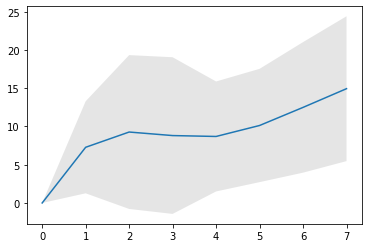

In [54]:
W = weights_to_matrix(res.x, G, targets)

errors = []
for night in nights[1:6]:
    gt = data[:, night].T / scale
    pred = gt.copy()
    for idx, ts in enumerate(night[:-1]):
        pred[idx+1, targets] = W.dot(pred[idx])
    errors.append(scale*(gt[:,targets]-pred[:,targets]).T)
errors = np.abs(np.concatenate(errors))

fig, ax = plt.subplots()
mu = np.mean(errors, axis=0)
std = np.std(errors, axis=0)
ax.plot(mu)
ax.fill_between(range(8), mu+std, mu-std, facecolor='gray', alpha=0.2);

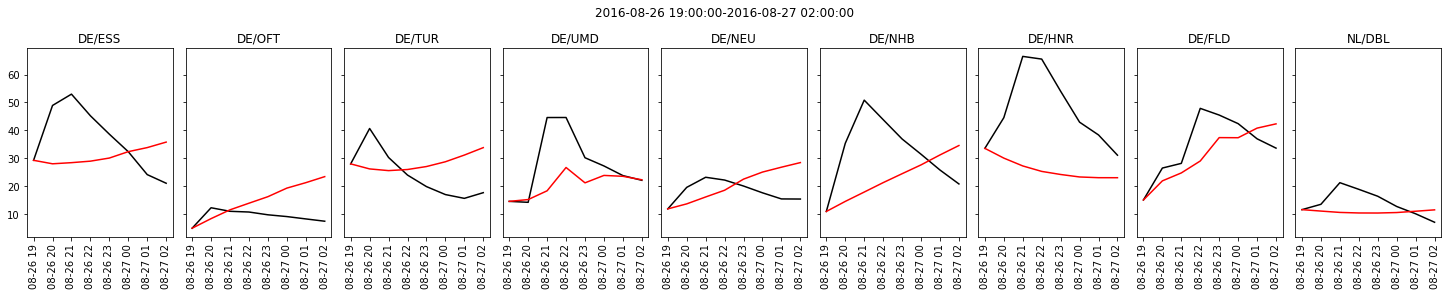

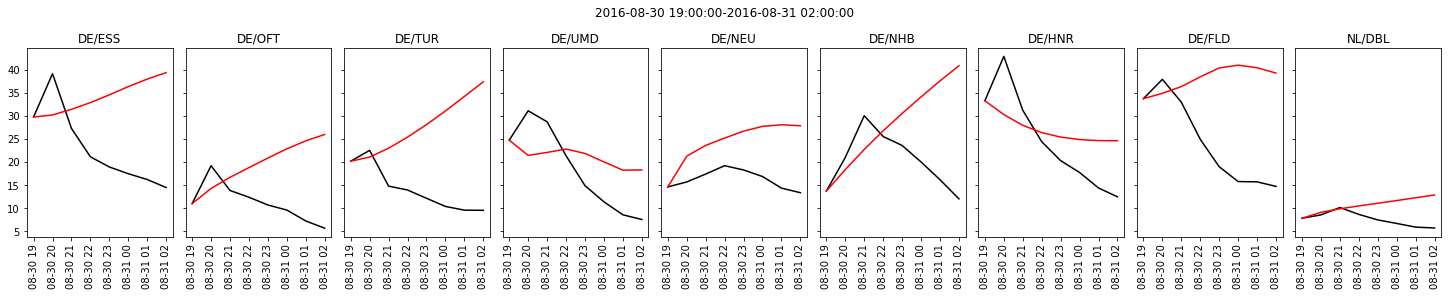

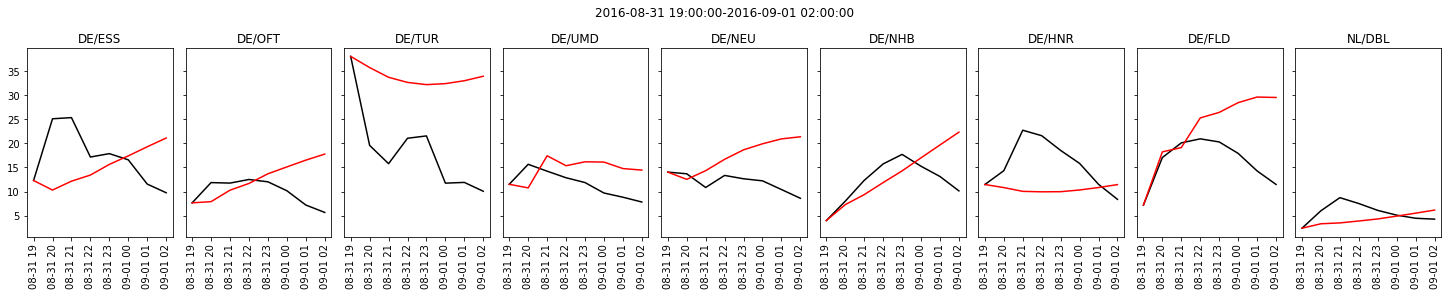

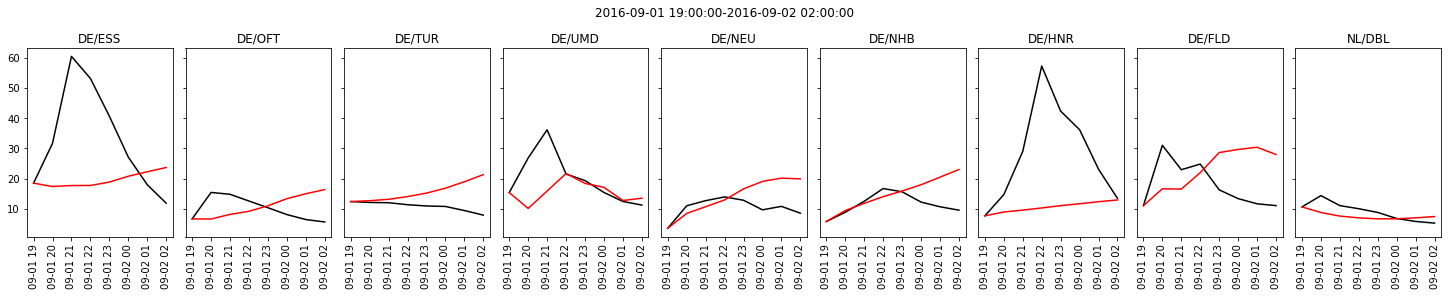

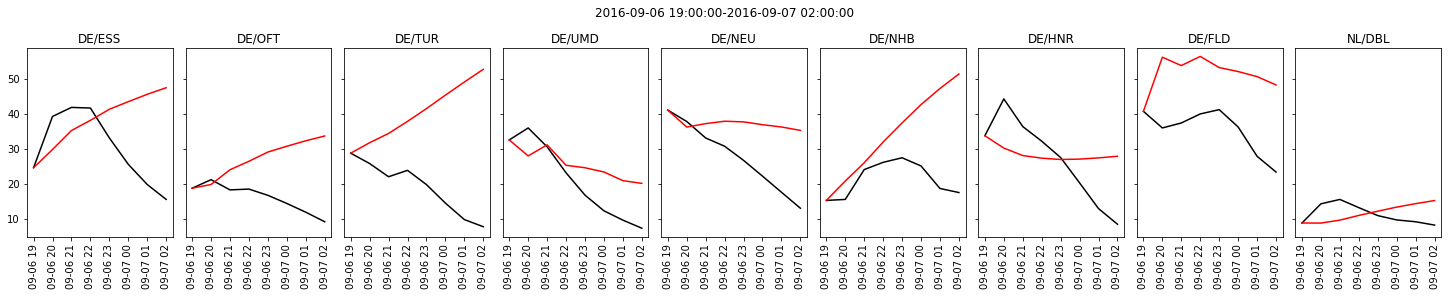

In [98]:
W = weights_to_matrix(res.x, G, targets)

for night in nights[1:6]:
    gt = data[:, night].T / scale
    pred = gt.copy()
    for idx, ts in enumerate(night[:-1]):
        pred[idx+1, targets] = W.dot(pred[idx])
        
    fig, ax = plt.subplots(1, len(targets), figsize=(20, 4), constrained_layout=True, sharey=True)
    for idx, node in enumerate(targets):
        ax[idx].plot(dft.iloc[night].index, gt[:, node]*scale, color='black')
        ax[idx].plot(dft.iloc[night].index, pred[:, node]*scale, color='red')
        ax[idx].tick_params(axis='x', rotation=90)
        ax[idx].set_title(list(names.values())[node])
    fig.suptitle(f'{time[night][0]}-{time[night][-1]}')

(9, 11) (9,)
(9, 8) (9,)
(9, 8) (9,)
(9, 8) (9,)
(9, 8) (9,)


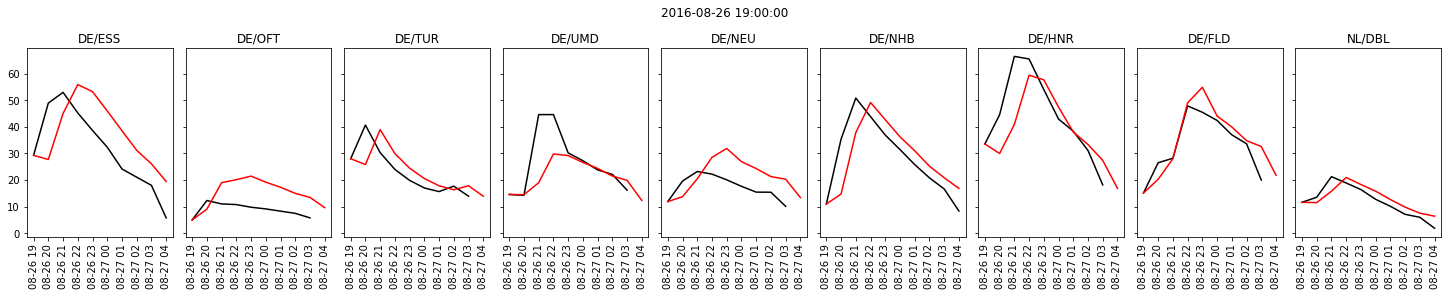

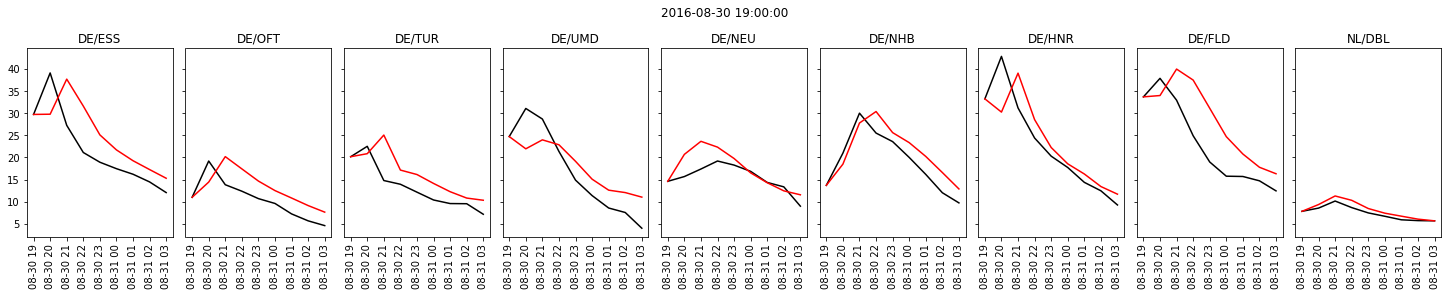

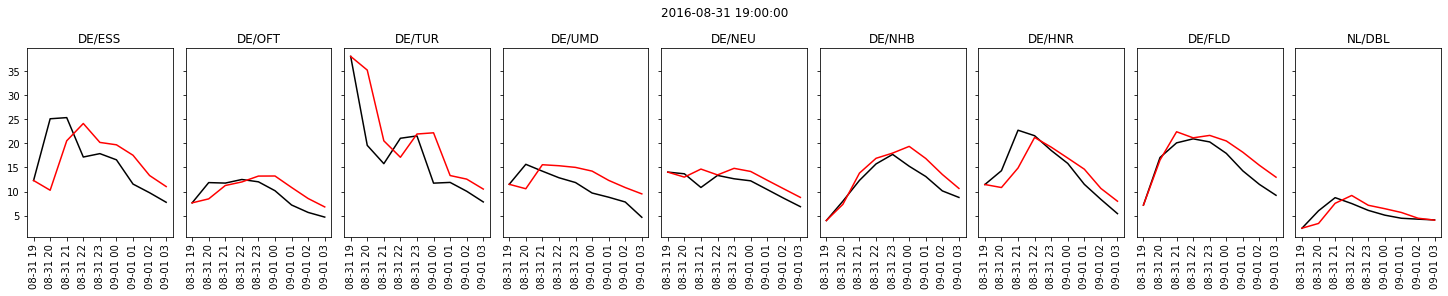

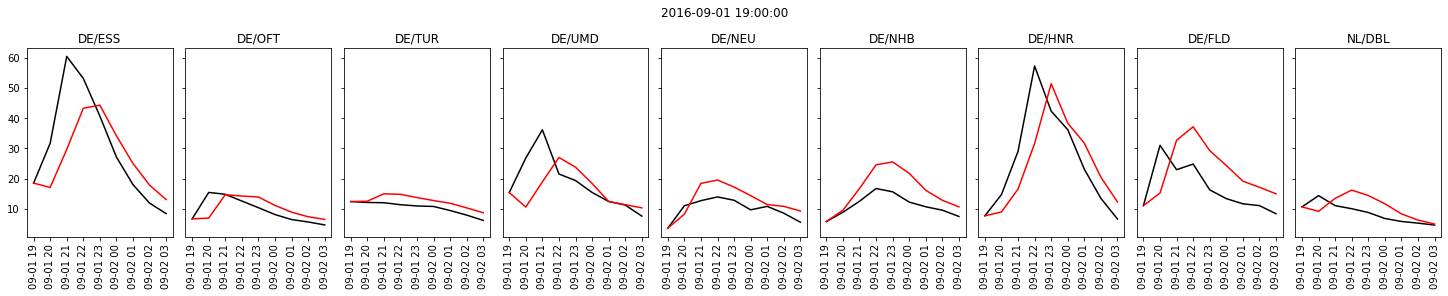

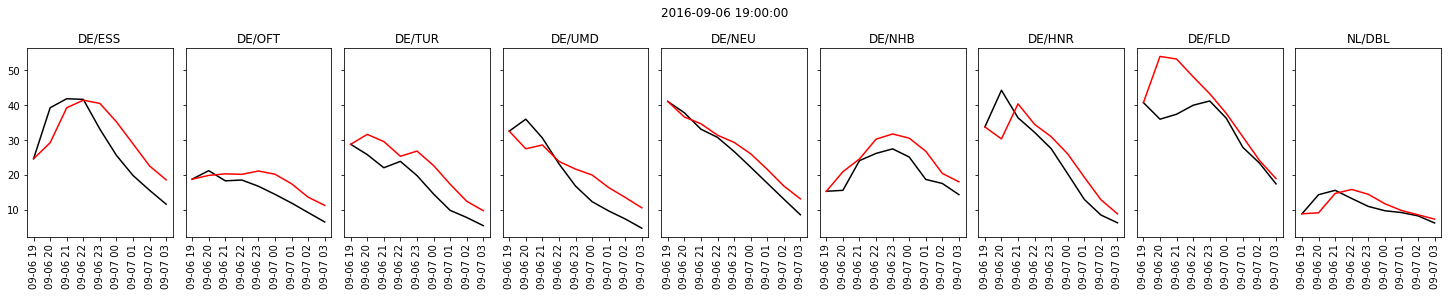

In [70]:
W = weights_to_matrix(res.x, G, targets)

for night in nights[1:6]:
    gt = data[:, night] / scale
    pred = W.dot(gt[:,:-1])
    pred = np.concatenate([gt[targets,0].reshape((len(targets), 1)), pred], axis=1)
        
    fig, ax = plt.subplots(1, len(targets), figsize=(20, 4), constrained_layout=True, sharey=True)
    for idx, node in enumerate(targets):
        ax[idx].plot(dft.iloc[night].index, gt[node, :]*scale, color='black')
        ax[idx].plot(dft.iloc[night].index, pred[idx, :]*scale, color='red')
        ax[idx].tick_params(axis='x', rotation=90)
        ax[idx].set_title(list(names.values())[node])
    fig.suptitle(f'{time[night][0]}-{time[night][-1]}')

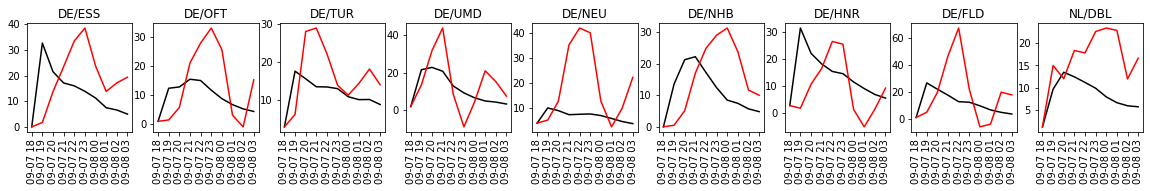

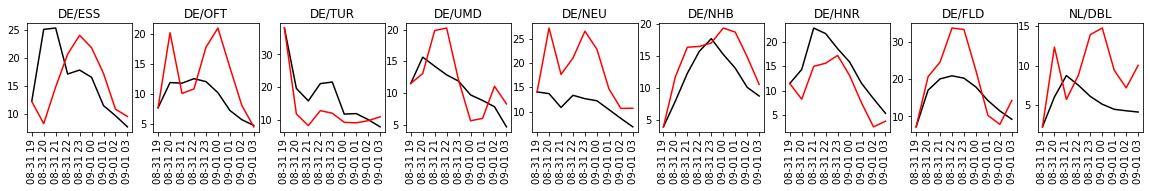

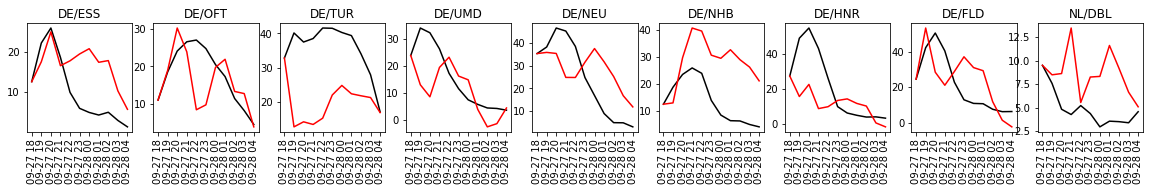

In [84]:
W = weights_to_matrix(res.x, G, targets)

for night in np.array(nights)[test_idx][:5]:
    night = night[2:]
    gt = X_seq[:, night].T
    pred = gt.copy()
    for idx, ts in enumerate(night[:-1]):
        pred[idx+1, targets] = W.dot(pred[idx])
        
    fig, ax = plt.subplots(1, len(targets), figsize=(20, 2))
    for idx, node in enumerate(targets):
        ax[idx].plot(dft.iloc[night].index, gt[:, node]*scale, color='black')
        ax[idx].plot(dft.iloc[night].index, pred[:, node]*scale, color='red')
        ax[idx].tick_params(axis='x', rotation=90)
        ax[idx].set_title(list(names.values())[node])

In [34]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, Y_train.T)

In [56]:
pred = [regr.predict(X_test[50].reshape(1, -1))]
for t in range(50):
    pred.append(regr.predict(pred[-1].reshape(1, -1)))

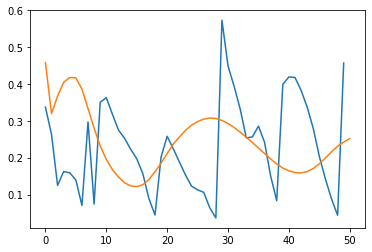

In [57]:
plt.plot(Y_test[3, 50:])
plt.plot(np.array(pred)[:,0,3])